In [2]:
import sys
!python --version
import numpy as np
import xarray as xr
import itertools as it
import multiprocessing as mp
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.rcsetup as rcsetup
import sklearn

CPU_COUNT = mp.cpu_count()
print('{} CPUs'.format(CPU_COUNT))
print('numpy version: {}'.format(np.__version__))
print('xarray version: {}'.format(xr.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
print('sklearn version: {}'.format(sklearn.__version__))

Python 3.7.1
8 CPUs
numpy version: 1.15.4
xarray version: 0.11.3
matplotlib version: 3.0.2
sklearn version: 0.20.1


## Experiment 1

#### North America regional average, 8 variables, CMIP5-rcp26

Shallow embeddings via DTW affinities

In [5]:
ds = xr.open_dataset('data/models_all_vars_vs_time.nc')
X_ds = ds.to_array().transpose('models', 'time', 'variable')
D_x = np.load('data/dtw.npy')
D2_x = np.load('data/dtw2.npy')
print(X_ds)
np.savetxt('data/dtw.csv', D_x, delimiter=',')

<xarray.DataArray (models: 40, time: 2880, variable: 6)>
array([[[-1.232390e+00, -8.221712e-01, ..., -1.762584e-07, -3.691904e-07],
        [-9.980754e-01, -3.134700e+00, ..., -3.496395e-06,  2.935993e-07],
        ...,
        [ 1.093070e+00,  9.386808e-01, ..., -3.006784e-06,  2.310148e-06],
        [ 1.049638e+00,  1.553081e+00, ...,  5.685991e-06,  2.558547e-06]],

       [[-6.226550e-01, -2.455808e-01, ...,  1.469825e-06,  5.744220e-07],
        [-8.767850e-01,  5.197417e-01, ..., -7.336508e-06, -3.874350e-08],
        ...,
        [ 9.840863e-01,  1.147870e+00, ..., -1.667757e-06,  2.476872e-07],
        [ 3.382746e-01,  7.926292e-01, ..., -5.932489e-06,  3.007603e-06]],

       ...,

       [[-1.374901e+00, -1.929253e+00, ...,  1.195963e-05, -6.273888e-06],
        [-5.095788e-01, -3.281883e+00, ...,  7.633096e-06,  1.095362e-06],
        ...,
        [ 4.450033e-01,  8.567608e-01, ..., -1.969318e-06,  2.737182e-06],
        [ 5.749437e-01,  1.901202e+00, ..., -3.146661e-06, -2.

In [5]:
all_models = X_ds.coords['models'].values
print(all_models)
print(len(all_models))
model_groups = dict()
for i, model in enumerate(all_models):
    pts = model.split('_')
    group_name, member_id = "".join(pts[:-1]), pts[-1]
    if group_name not in model_groups:
        model_groups[group_name] = []
    model_groups[group_name].append(i)

['CCSM4_1' 'CCSM4_2' 'CCSM4_3' 'CCSM4_4' 'CCSM4_6' 'CESM1-CAM5_1'
 'CESM1-CAM5_2' 'CESM1-CAM5_3' 'CNRM-CM5_1' 'CSIRO-Mk3-6-0_1'
 'CSIRO-Mk3-6-0_2' 'CSIRO-Mk3-6-0_3' 'CSIRO-Mk3-6-0_5' 'CSIRO-Mk3-6-0_6'
 'CSIRO-Mk3-6-0_8' 'CSIRO-Mk3-6-0_9' 'CanESM2_1' 'CanESM2_3' 'CanESM2_4'
 'CanESM2_5' 'FGOALS_g2_1' 'FIO-ESM_2' 'FIO-ESM_3' 'GFDL-ESM2G_1'
 'GFDL-ESM2M_1' 'GISS-E2-H_1' 'HadGEM2-ES_2' 'HadGEM2-ES_4'
 'IPSL-CM5A-LR_1' 'IPSL-CM5A-LR_2' 'IPSL-CM5A-LR_3' 'MIROC-ESM-CHEM_1'
 'MIROC-ESM_1' 'MIROC5_1' 'MPI-ESM-LR_1' 'MPI-ESM-LR_2' 'MPI-ESM-LR_3'
 'MPI-ESM-MR_1' 'MRI-CGCM3_1' 'NorESM1-M_1']
40


In [52]:
%matplotlib inline
def plot_model_embedding(X_emb, title=''):
    plt.figure(figsize=(8,6))
    cmap = cm.get_cmap('tab20')
    colors = [cmap(x) for x in np.linspace(0, 1, len(model_groups))]
    markers = ['o','s','D','v','^']
    for i, (name, inds) in enumerate(model_groups.items()):
        plt.scatter(X_emb[inds,0], X_emb[inds,1], s=36, marker=markers[i % len(markers)], c=[colors[i]], label=name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=2)
    plt.title(title)
    plt.show()

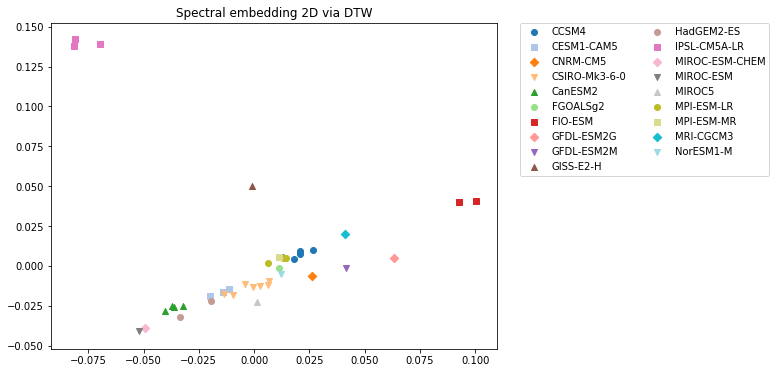

In [71]:
from sklearn.manifold import SpectralEmbedding

# compute affinity matrix from DTW distances
W = np.zeros(D_x.shape)
eps = 2.0
t = 1.0
for i, row in enumerate(W):
    for j, _ in enumerate(row):
        d = D2_x[i,j]
        W[i,j] = np.exp(-d / t) if i != j and d < eps else 0.0
        
# compute spectral embedding and plot
np.savetxt('data/W.csv', W, delimiter=',')
spectral = SpectralEmbedding(affinity='precomputed')
D_spec = spectral.fit_transform(W)
plot_model_embedding(D_spec, "Spectral embedding 2D via DTW")

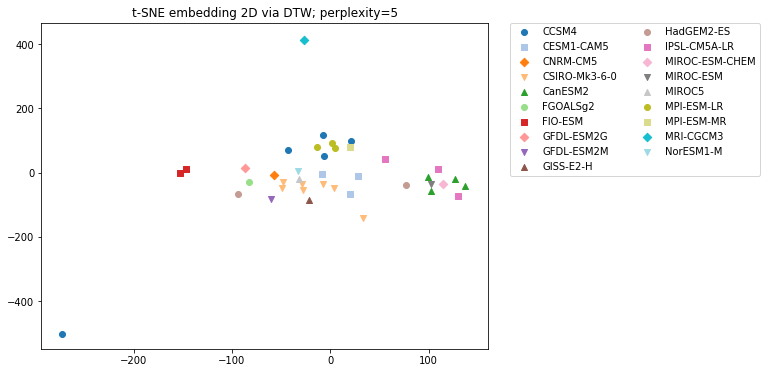

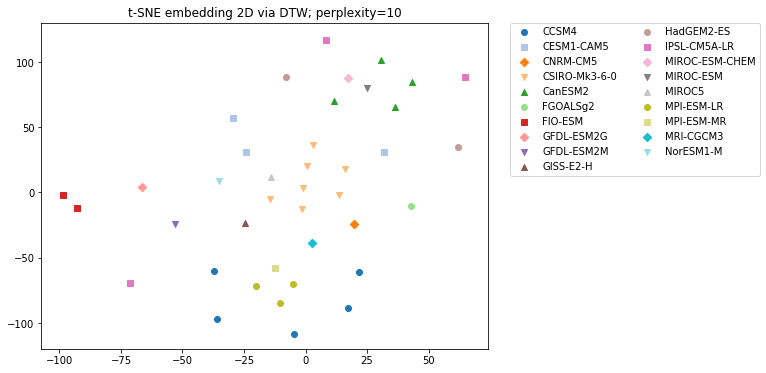

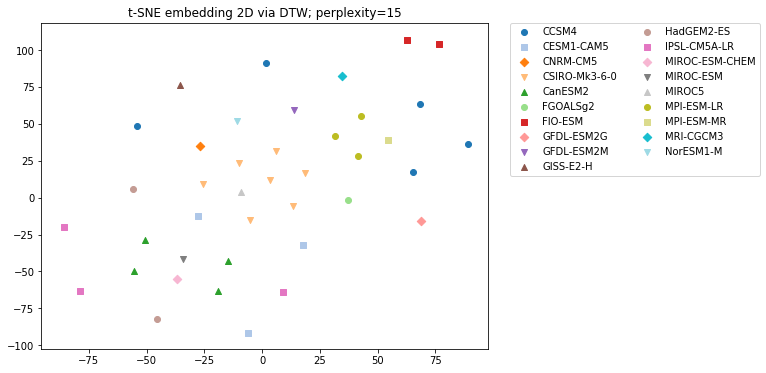

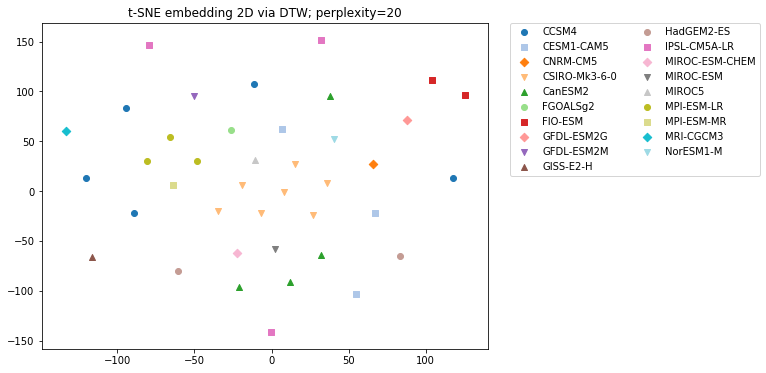

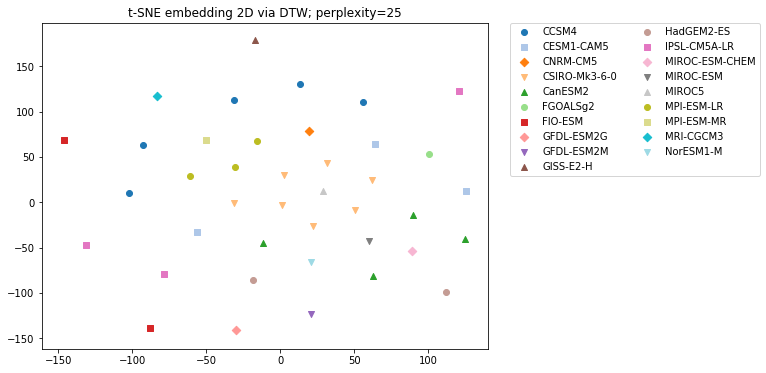

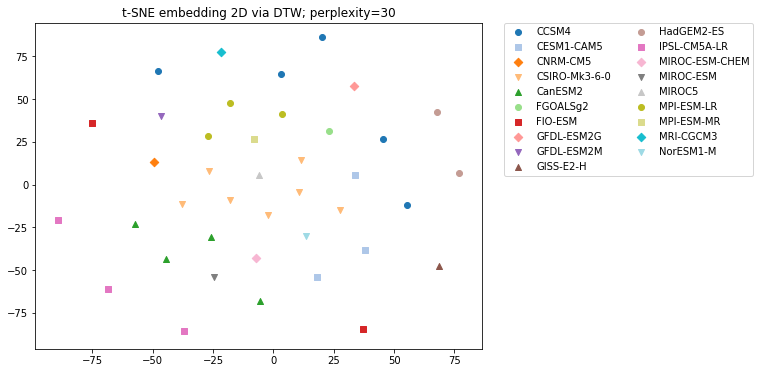

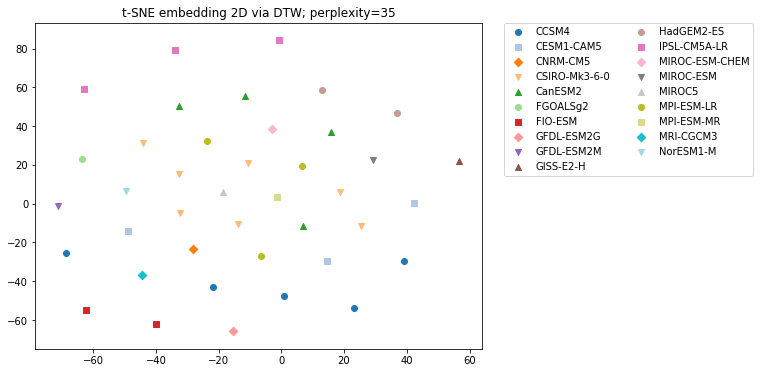

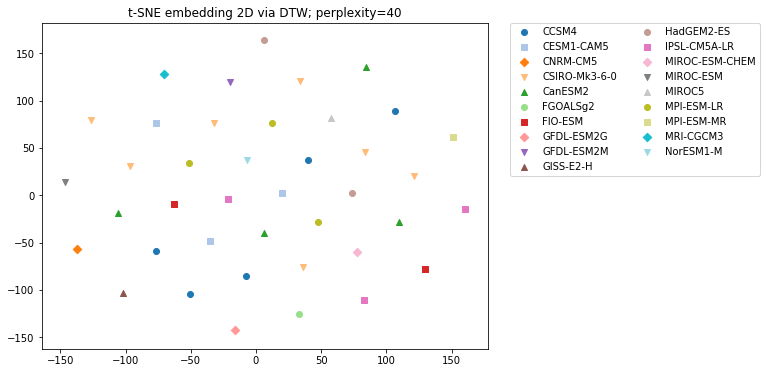

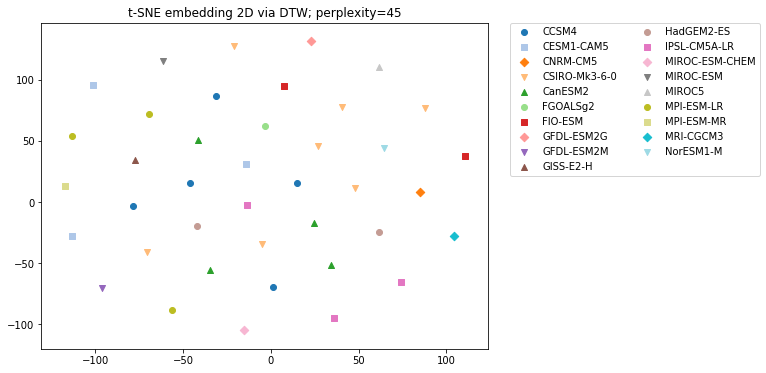

In [72]:
from sklearn.manifold import TSNE

perplexities = np.arange(5, 50, 5)
N_iter = 10
for p in perplexities:
    tsne = TSNE(perplexity=p, metric='precomputed')
    D_tsne = tsne.fit_transform(D2_x)
    plot_model_embedding(D_tsne, "t-SNE embedding 2D via DTW; perplexity={}".format(p))

/home/brian/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


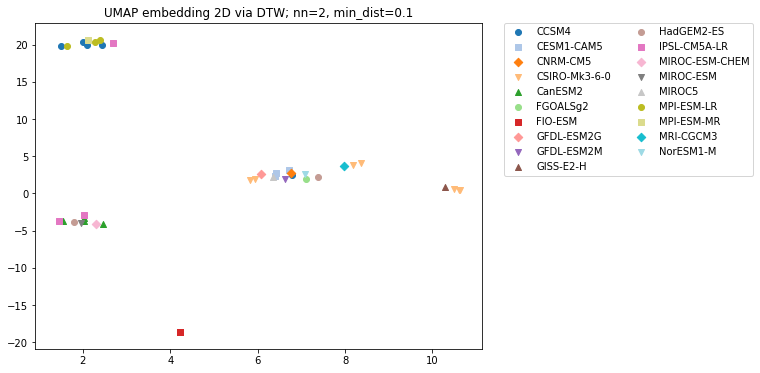

/home/brian/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


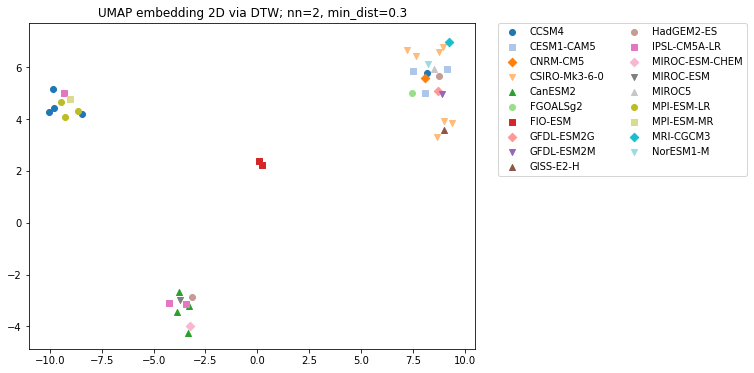

/home/brian/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


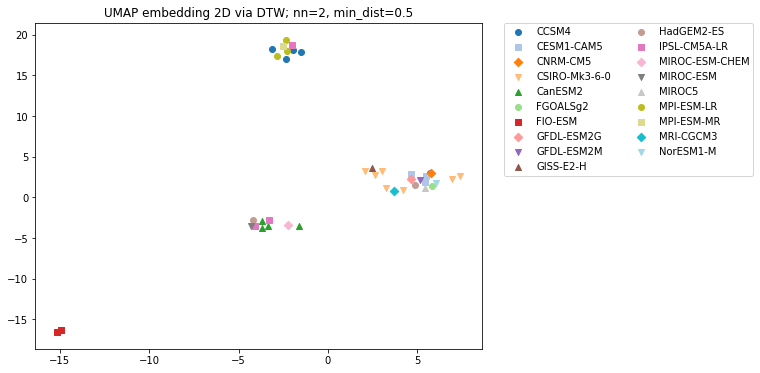

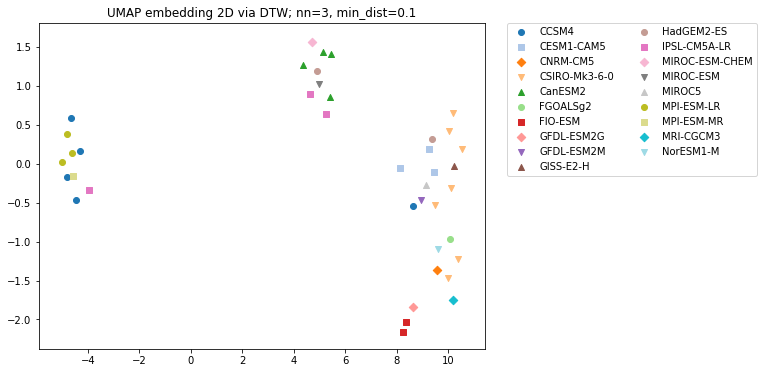

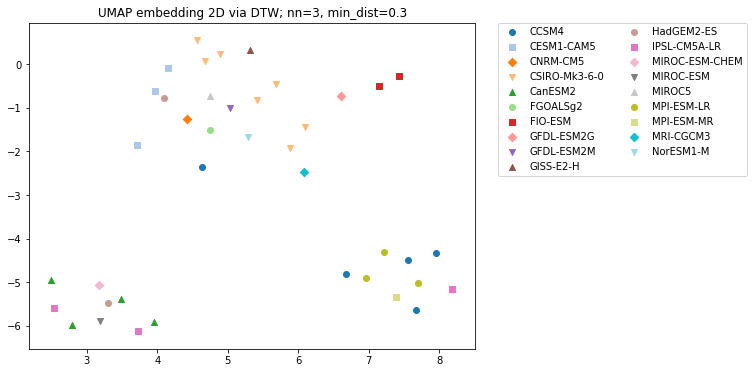

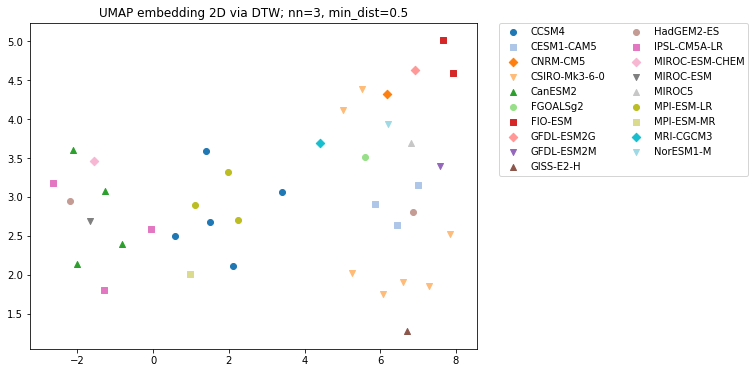

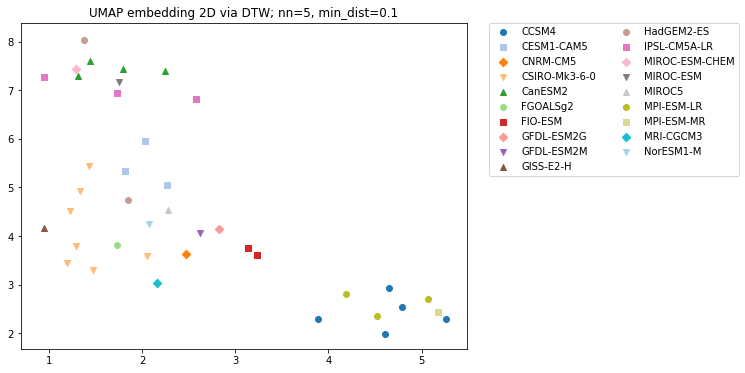

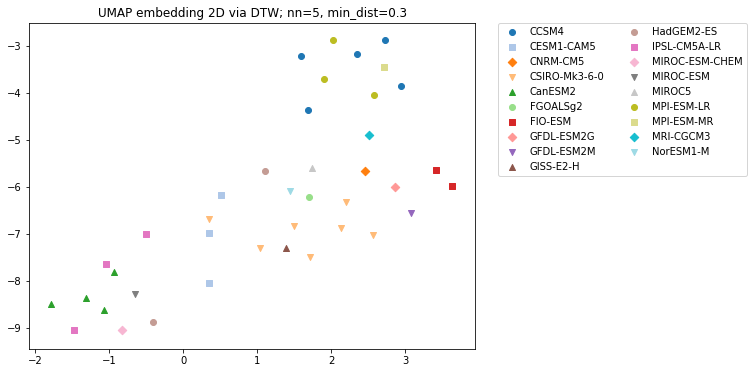

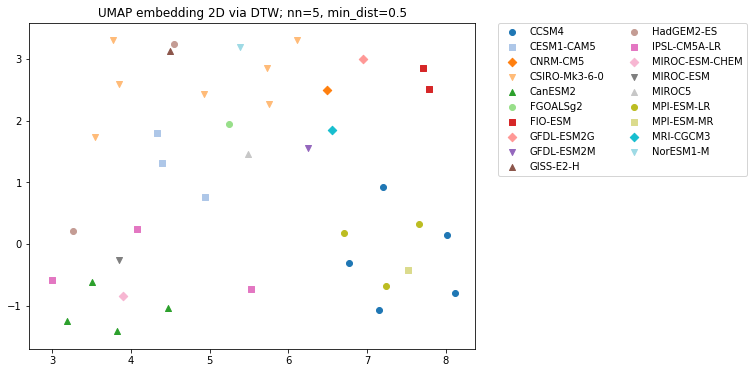

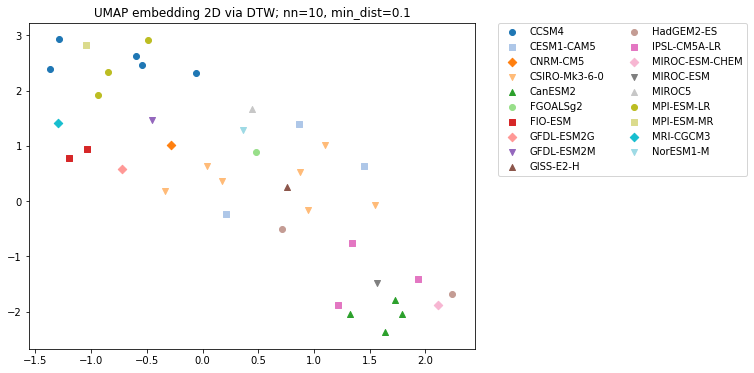

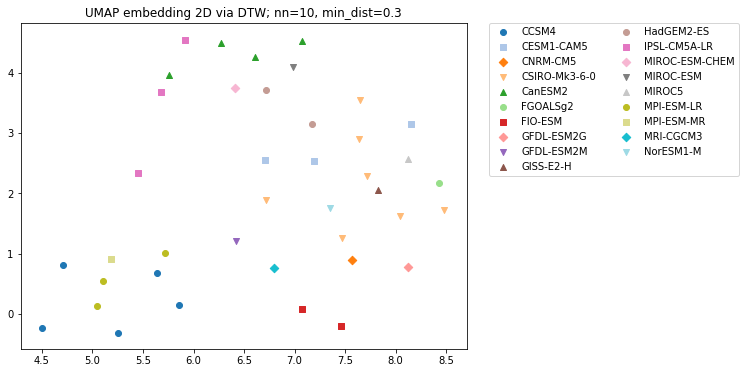

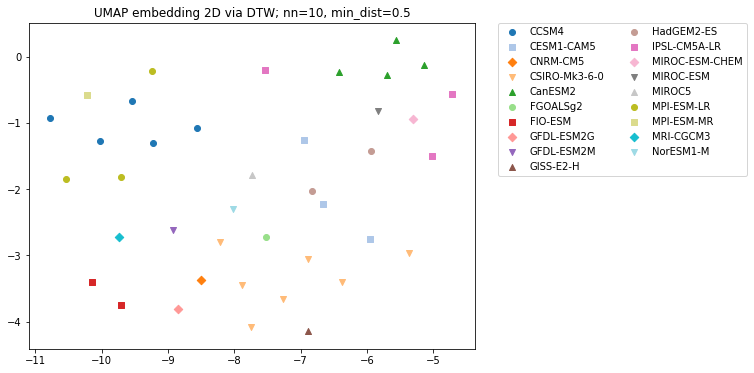

In [73]:
from umap import UMAP

umap = UMAP(metric='precomputed')
nns = [2,3,5,10]
min_dist = [0.1,0.3,0.5]
for nn, d in it.product(nns, min_dist):
    umap = UMAP(n_neighbors=nn, min_dist=d, metric='precomputed')
    D_umap = umap.fit_transform(D2_x)
    plot_model_embedding(D_umap, "UMAP embedding 2D via DTW; nn={}, min_dist={}".format(nn, d))